In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e, k
from scipy.interpolate import interp1d
import itertools
k=1/1160

## $$ \gamma  \to \Gamma \frac{ e^{\frac{\epsilon _o}{\text{kT}}}+\text{N}}{e^{\frac{\epsilon _o}{\text{kT}}}-1} \ \ \ \ \ \ \ \ \          \eta    \to \frac{\gamma N}{4 \text{kT} \cosh ^2\left(\frac{\epsilon _o}{2 \text{kT}}\right)} \ \ \ \ \ \ \                          \lambda \to \frac{e^{\frac{\epsilon _o}{\text{kT}}}+1}{e^{\frac{\epsilon _o}{\text{kT}}}+\text{N}} $$   


In [3]:
def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator
    

## $$ C = e^2 \left(p_o \left(\text{dn}_g-\text{dn}_e\right)+\text{dn}_e\right)+\frac{ e^2 \eta  \lambda ^2 \text{ds}_{\text{mg}} \left(n_g-n_e\right)}{\gamma ^2+w^2} \gamma $$

$$ p_o = \frac{e^{\frac{\epsilon _o}{\text{kT}}}}{e^{\frac{\epsilon _o}{\text{kT}}}+\text{nN}} $$

## $$\frac{1}{R} = -\frac{e^2 \eta  \lambda ^2 \text{ds}_{\text{mg}} \left(n_e-n_g\right)}{\gamma ^2+w^2} w^2$$

In [21]:
def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dng - dne) + dne)

def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

def I_resistance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = -(e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator



In [5]:
# p0(0.1,100,10)
# q_capacitance(0.1,100,10,0.1,0.1)
# tunnel_capacitance(1e4,0.1,0.01,100,10,0.1,0.12,1e6)
# total_capacitance(1e4,0.1,0.01,100,10,0.1,0.12,0.01,0.02,1e6)
# I_resistance(1e4,0.1,0.01,100,10,0.1,0.12,1e6)

In [59]:
def capacitance_data(gammaa,v0,g0,T,N,w,U=0.333):

    op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg

    chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi1.dat") # dng
    n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat") # ng

    chi2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi2.dat") # dne
    n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat") # ne


    s_mg_f = interp1d(op1[:,0],op1[:,1])
    ds_mg_f = interp1d(op1[:,0],np.gradient(op1[:,1],-0.01*U))

    n_g_f = interp1d(n1[:,0],n1[:,1])
    chi_g_f = interp1d(chi1[:,0],chi1[:,1])
    n_e_f = interp1d(n2[:,0],n2[:,1])
    chi_e_f = interp1d(chi2[:,0],chi2[:,1])
    

    s_mg = s_mg_f(v0)
    ds_mg = ds_mg_f(v0)

    n_g = n_g_f(v0)
    dn_g = chi_g_f(v0)
    n_e = n_e_f(v0)
    dn_e = chi_e_f(v0)
    
    return total_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, dn_e, dn_g, w)

In [60]:
def capacitance_data0(gammaa,v0,g0,T,N,w,U=0.333):

    op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg

    chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi1.dat") # dng
    n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat") # ng

    chi2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi2.dat") # dne
    n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat") # ne


    s_mg_f = interp1d(op1[:,0],op1[:,1])
    ds_mg_f = interp1d(op1[:,0],np.gradient(op1[:,1],-0.01*U))

    n_g_f = interp1d(n1[:,0],n1[:,1])
    chi_g_f = interp1d(chi1[:,0],chi1[:,1])
    n_e_f = interp1d(n2[:,0],n2[:,1])
    chi_e_f = interp1d(chi2[:,0],chi2[:,1])
    

    s_mg = s_mg_f(v0)
    ds_mg = ds_mg_f(v0)

    n_g = n_g_f(v0)
    dn_g = chi_g_f(v0)
    n_e = n_e_f(v0)
    dn_e = 0 #chi_e_f(v0)
    
    return total_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, dn_e, dn_g, w)

In [61]:
capacitance_data(0.035,0.3,1e6,40,10,1e7)

1.6413120499424118e-38

In [62]:
def res_data(gammaa,v0,g0,T,N,w,U=0.333):

    op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg

    # chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi1.dat") # dng
    n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat") # ng

    # chi2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi2.dat") # dne
    n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat") # ne


    s_mg_f = interp1d(op1[:,0],op1[:,1])
    ds_mg_f = interp1d(op1[:,0],np.gradient(op1[:,1],-0.01*U))

    n_g_f = interp1d(n1[:,0],n1[:,1])
    # chi_g_f = interp1d(chi1[:,0],chi1[:,1])
    n_e_f = interp1d(n2[:,0],n2[:,1])
    # chi_e_f = interp1d(chi2[:,0],chi2[:,1])
    

    s_mg = s_mg_f(v0)
    ds_mg = ds_mg_f(v0)

    n_g = n_g_f(v0)
    # dn_g = chi_g_f(v0)
    n_e = n_e_f(v0)
    # dn_e = chi_e_f(v0)
    
    return n_g - n_e #I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)

In [63]:
res_data(0.035,0.3,1e6,40,10,1e7)

-0.7688311055388919

In [10]:
def caps_exp(dset):
    text = f"f1web.ijs.si\\~zitko\\data\\chi\\experimental_data\\dataset_{dset}.csv"
    dataset = np.loadtxt(text, skiprows=1,delimiter=',')[:,0:2]
    exp_caps12 = dataset[:,1]
    vex = dataset[:,0]*1e3
    filter_arry = (vex<0.6)*(-0.6<vex)
    exp_cap1 = exp_caps12[filter_arry]
    vex1 = vex[filter_arry]
    return vex1, exp_cap1

In [19]:
# gammaa = '0.035'

def capplot(gammaa,g0vals,Tvals,Nvals,save=False,format='png'):
    params = list(itertools.product(g0vals,Tvals,Nvals))

    fig, axes = plt.subplots(int(np.ceil(len(params)/4)),4,figsize=(20,4*int(np.ceil(len(params)/4))))
    axes = axes.flatten()
    idx = 0
    v0 = np.arange(-0.6,0.6,.01)
    w = 268*1e6
    for parameter in params:
        g0, T, N = parameter

        cvalues = capacitance_data(gammaa,1+2*v0,g0,T,N,w)*1e15
        cvalues0 = capacitance_data0(gammaa,1+2*v0,g0,T,N,w)*1e15

        label = f'$\Gamma^0 = 10^{(int(np.log10(g0)))}$ \n T = {T} \n N = $10^{(int(np.log10(N)))}$'
        axes[idx].plot(v0,cvalues,label=label)
        axes[idx].plot(v0,cvalues0,label=f'$dn_e = 0$ \n'+label)
        axes[idx].set_ylabel(f'$ C (fF) $')
        axes[idx].set_xlabel(f'$ c_1 \epsilon_o + c_2 $')
        # axes[idx].set_title(label)
        axes[idx].legend(fontsize=12)
        idx = idx + 1

    parameter_string = f"\
            $U          = 0.333 $\
            $\\Gamma_t      = {gammaa} $\
            $\\omega      = 268 MHz $"

    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if save:
        plt.savefig(f"plots2{gammaa}.{format}", format=format)




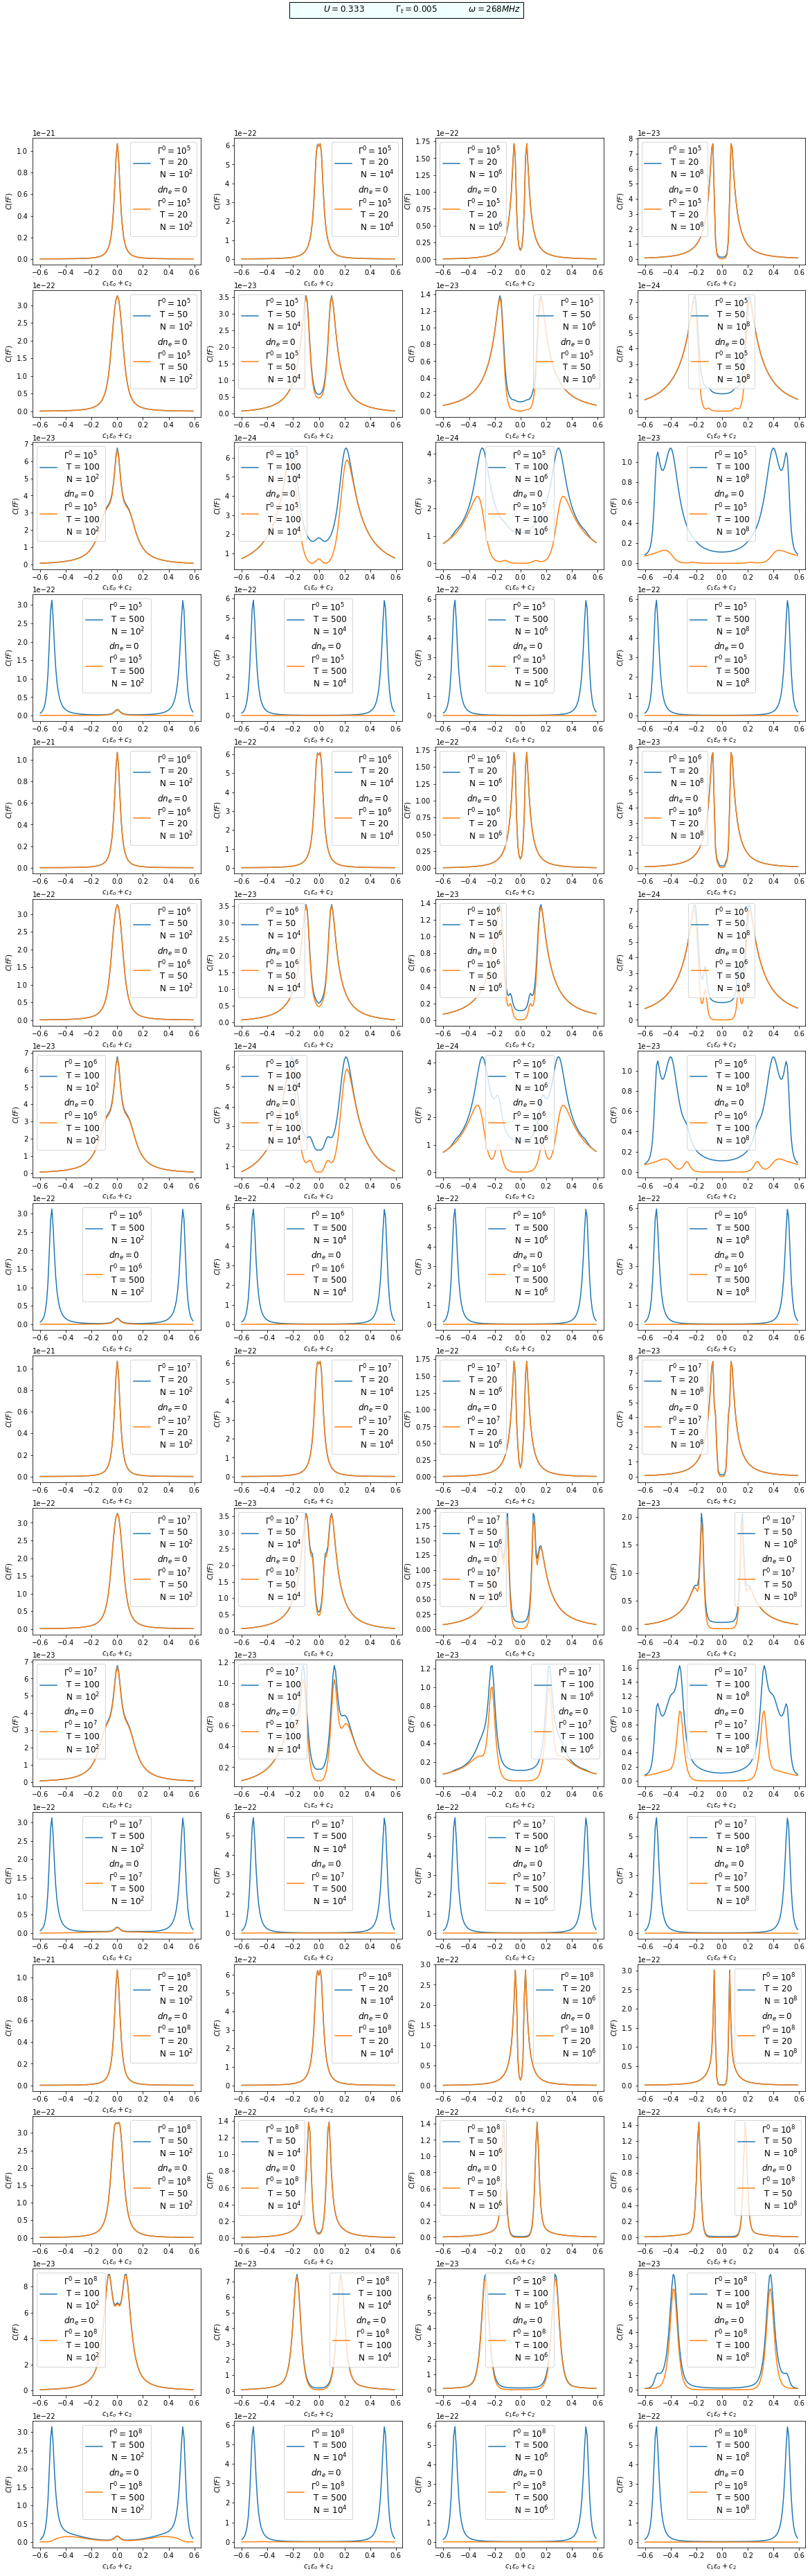

In [20]:
capplot('0.005',[1e5,1e6,1e7,1e8],[20,50,100,500],[1e2,1e4,1e6,1e8],save=False,format='pdf')


In [39]:
# gammaa = '0.035'

def resplot(gammaa,g0vals,Tvals,Nvals,save=False,format='png'):
    params = list(itertools.product(g0vals,Tvals,Nvals))

    fig, axes = plt.subplots(int(np.ceil(len(params)/4)),4,figsize=(20,4*int(np.ceil(len(params)/4))))
    axes = axes.flatten()
    idx = 0
    v0 = np.arange(-0.6,0.6,.01)
    w = 268*1e6
    for parameter in params:
        g0, T, N = parameter

        cvalues = res_data(gammaa,1+2*v0,g0,T,N,w)

        label = f'$\Gamma^0 = 10^{(int(np.log10(g0)))}$ \n T = {T} \n N = $10^{(int(np.log10(N)))}$'
        axes[idx].plot(v0,cvalues,label=label)
        axes[idx].set_ylabel(f'$ \\frac{{1}}{{R}} \Omega $')
        axes[idx].set_xlabel(f'$ c_1 \epsilon_o + c_2 $')
        # axes[idx].set_title(label)
        axes[idx].legend(fontsize=12)
        idx = idx + 1

    parameter_string = f"\
            $U          = 0.333 $\
            $\\Gamma_t      = {gammaa} $\
            $\\omega      = 268 MHz $"

    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if save:
        plt.savefig(f"plotsres{gammaa}.{format}", format=format)




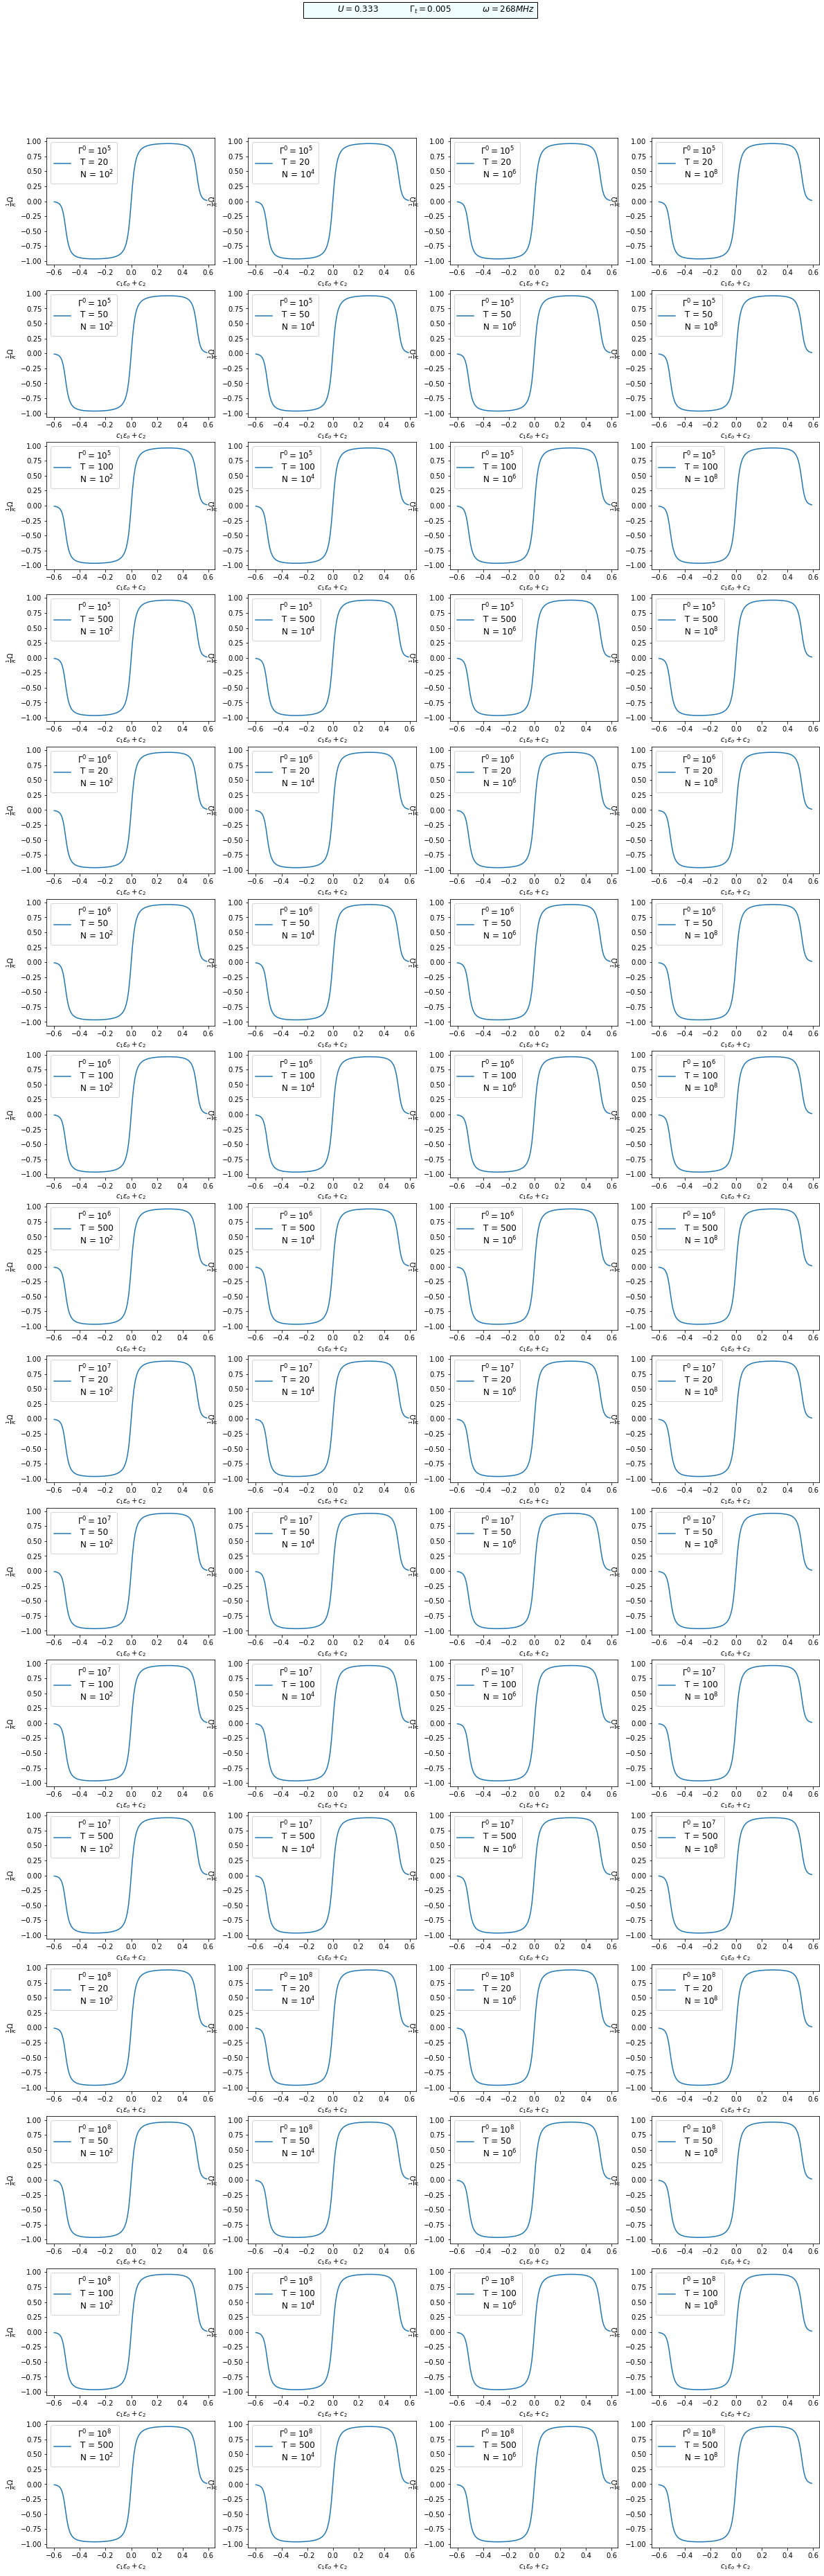

In [40]:
resplot('0.005',[1e5,1e6,1e7,1e8],[20,50,100,500],[1e2,1e4,1e6,1e8],save=False,format='pdf')


In [ ]:
def symplot(g0): 
    sets = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    gammas = ["0.0425", "0.050", "0.03125", "0.02875", "0.02375", "0.020","0.015", "0.01125", "0.00875"]
    rok_fit = [10.67, 1.088, 35.67, 0.01932]
    Ne, scalex, scaley, T = rok_fit
    T = T/k
    N = 10**Ne
    g0 = 1e8
    vx = np.arange(-0.6,0.6,.01)
    v0 = 1 + (scalex*np.arange(-0.6,0.6,.01))
    w = 268*1e6

    fig = plt.figure(constrained_layout=True,figsize=(20,45))
    # fig.suptitle(f'U = 0.333, $\Gamma_0$ = {g0:.0e}',fontsize=14)

    fig.suptitle(f'U = 0.333, $\\Gamma_0$ = {g0:.0e} Hz, Sym, N=10^{Ne}, Scalex = {scalex}, Scaley = {scaley}, T = {T} mK')

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=9, ncols=1)

    for dset, gamma_t, subfig in zip(sets, gammas,subfigs):
        subfig.suptitle(f'$\\Gamma_t$ = {gamma_t}  dataset = {dset}')
        axis = subfig.subplots(nrows=1, ncols=4)
        op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gamma_t}\\optical1.dat")
        chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gamma_t}\\chi1.dat")
        n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gamma_t}\\n1.dat")
        n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gamma_t}\\n1.dat")
        vex, exp_caps = caps_exp(dset)

        gap = interp1d(op1[:,0],op1[:,1])
        dgap = interp1d(op1[:,0],np.gradient(op1[:,1],0.01))
        chi = interp1d(chi1[:,0],chi1[:,1])
        nng = interp1d(n1[:,0],n1[:,1])



        ng = nng(v0)
        smg = gap(v0)
        dsmg = dgap(v0)
        dng = chi(v0)
        model_cap = scaley*extd_capacitance(g0, smg, T, N, w, ng, dsmg, dng)/(e*e)
        rok_cap = scaley*rok_capacitance(g0, smg, T, N, w, ng, dsmg, dng)/(e*e)
        exp_caps = 1e18*(exp_caps + exp_caps[::-1])/2

        axis[0].plot(vex,exp_caps,label='experiment')
        axis[1].plot(vex,exp_caps,label='experiment')
        axis[0].plot(vx,rok_cap,label='Rok')
        axis[1].plot(vx,model_cap,label='esterli N States')
        axis[2].plot(vx,smg, label = f'$\\delta / \\Delta $')
        axis[3].plot(vx,ng, label = f'$n_g$')

        axis[0].set_ylim(-5,350)
        axis[1].set_ylim(-5,350)
        axis[2].set_ylim(0.0,1.4)
        axis[3].set_ylim(0,2.1)

        axis[0].set_ylabel(f'$S_y$ Capacitance, (aF)')
        # axis[1].set_ylabel(f'$S_y$ Capacitance, (F/e)')


        for haxis in axis:
            haxis.legend()
            haxis.set_xlim(-0.63,0.63)
            haxis.set_xlabel(f'$\epsilon_0 (mV) $')


    # ptext = f'U = 0.333, $\\Gamma_0$ = {g0:.0e}, Sym, N={Ne}, Scalex = {scalex}, Scaley = {scaley}'
    # fig.text(0.24, 0.999, ptext,ha='center', va='center', wrap=False, 
    #     bbox=dict(ec='black', alpha=1, color='azure'), fontsize=15)

    g0log = int(np.log10(g0))
    plt.savefig(f"Gamma0 = 10^{g0log}.{'pdf'}", format='pdf')

In [ ]:
def nonsym(g0):
    sets = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    # gammas = ["0.0425", "0.050", "0.03125", "0.02875", "0.02375", "0.020","0.015", "0.01125", "0.00875"]
    gammas = ["0.040", "0.0475", "0.02875", "0.02625", "0.02125", "0.0175", "0.01375", "0.00875", "0.0075"]
    rok_fit = [9.84, 1.042, 35.12, 0.0200]
    Ne, scalex, scaley, T = rok_fit
    T = T/k
    N = 10**Ne
    # g0 = 1e5
    vx = np.arange(-0.6,0.6,.01)
    v0 = 1 + (scalex*np.arange(-0.6,0.6,.01))

    fig = plt.figure(constrained_layout=True,figsize=(20,45))
    # fig.suptitle(f'U = 0.333, $\Gamma_0$ = {g0:.0e}',fontsize=14)

    fig.suptitle(f'U = 0.333, $\\Gamma_0$ = {g0:.0e} Hz, Not Sym, N=10^{Ne}, Scalex = {scalex}, Scaley = {scaley}, T = {T} mK')

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=9, ncols=1)

    for dset, gamma_t, subfig in zip(sets, gammas,subfigs):
        subfig.suptitle(f'$\\Gamma_t$ = {gamma_t}  dataset = {dset}')
        axis = subfig.subplots(nrows=1, ncols=4)
        op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gamma_t}\\optical1.dat")
        chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gamma_t}\\chi1.dat")
        n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gamma_t}\\n1.dat")
        vex, exp_caps = caps_exp(dset)

        gap = interp1d(op1[:,0],op1[:,1])
        dgap = interp1d(op1[:,0],np.gradient(op1[:,1],0.01))
        chi = interp1d(chi1[:,0],chi1[:,1])
        nng = interp1d(n1[:,0],n1[:,1])

        w = 268*1e6

        ng = nng(v0)
        smg = gap(v0)
        dsmg = dgap(v0)
        dng = chi(v0)
        model_cap = scaley*extd_capacitance(g0, smg, T, N, w, ng, dsmg, dng)/(e**2)
        rok_cap = scaley*rok_capacitance(g0, smg, T, N, w, ng, dsmg, dng)/(e**2)
        exp_caps = (1e18)*exp_caps

        axis[0].plot(vex,exp_caps,label='experiment')
        axis[1].plot(vex,exp_caps,label='experiment')
        axis[0].plot(vx,rok_cap,label='Rok')
        axis[1].plot(vx,model_cap,label='esterli N States')
        axis[2].plot(vx,smg, label = f'$\\delta / \\Delta $')
        axis[3].plot(vx,ng, label = f'$n_g$')

        axis[0].set_ylim(-5,350)
        axis[1].set_ylim(-5,350)
        axis[2].set_ylim(0.0,1.4)
        axis[3].set_ylim(0,2.1)

        axis[0].set_ylabel(f'$S_y$ Capacitance, (aF)')
        # axis[1].set_ylabel(f'$S_y$ Capacitance, (F/e)')


        for haxis in axis:
            haxis.legend()
            haxis.set_xlim(-0.63,0.63)
            haxis.set_xlabel(f'$\epsilon_0 (mV) $')
    g0log = int(np.log10(g0))
    # plt.savefig(f"NS Gamma0 = 10^{g0log}.{'pdf'}", format='pdf')

In [ ]:
for g00 in [1e5,1e6,1e7,1e8]:
    symplot(g00)

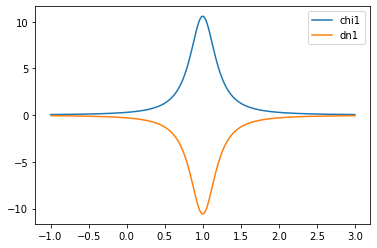

In [64]:
gammaa = '0.035'

n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gammaa}\\n1.dat") # ng
chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U=0.333\\U=0.333_Gamma={gammaa}\\chi1.dat") # chi1
dn1 = np.gradient(n1[:,1],-0.01*0.333)


plt.plot(chi1[:,0],chi1[:,1],label='chi1')
plt.plot(n1[:,0],dn1,label='dn1')
plt.legend()